# 3. Deep Ritz Method

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 3.1 The Poisson equation in two dimension

<p style='font-size:18px; line-height:2.5em'> Consider the Poisson equation : \begin{eqnarray} -\Delta u =& 0 &&\text{ for } x \in (0,1)^2, \\ u=&xy &&\text{ for } x \in \partial(0,1)^2. \end{eqnarray} Then the solution is simply $u(x,y) = xy$
    
<p style='font-size:18px; line-height:2.5em'> The loss function is given by \begin{equation} \int_{(0,1)^2} \frac{1}{2} |\nabla u_{nn}|^2 dxdy + \beta \cdot \int_{\partial (0,1)^2} (u_{nn}(x,y) - xy)^2 dxdy. \end{equation}

# Dataset generation

In [4]:
Nx = 50                                                   # Number of samples
Ny = 50                                                   # Number of samples
x = torch.linspace(0, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(0, 1, Ny)                             # Input data for y (N x 1)

xy = torch.meshgrid(x,y)
xy_grid = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)

x_bdry = xy_grid[torch.logical_or((xy_grid[:,0]==1), (xy_grid[:,0]==0))]
y_bdry = xy_grid[torch.logical_or((xy_grid[:,1]==1), (xy_grid[:,1]==0))]
xy_bdry = torch.cat([x_bdry, y_bdry])
u_bdry = (xy_bdry[:,0]*xy_bdry[:,1]).view(-1,1)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
plt.figure(figsize=(7,7))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

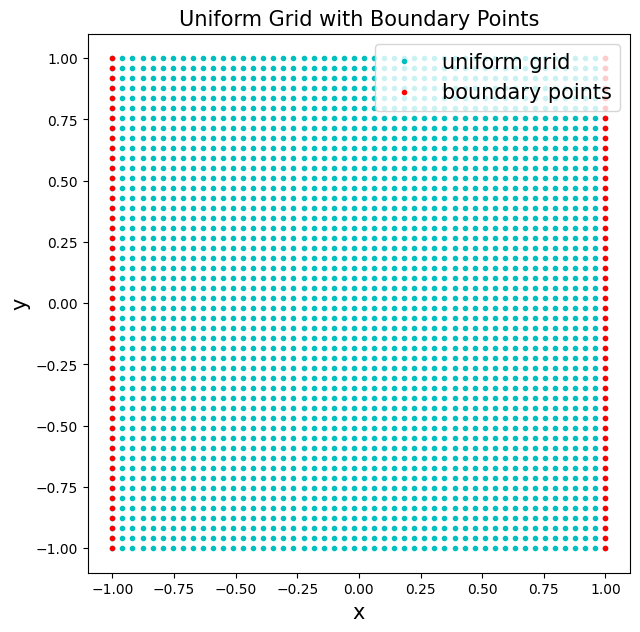

In [6]:
Nx = 50  # Number of samples
Ny = 50  # Number of samples
x = torch.linspace(-1, 1, Nx)  # Input data for x (Nx x 1)
y = torch.linspace(-1, 1, Ny)  # Input data for y (Ny x 1)

xy = torch.meshgrid(x, y)
xy_grid = torch.cat([xy[0].reshape(-1, 1), xy[1].reshape(-1, 1)], dim=1)

# Define the boundary points in x and y directions
x_bdry = xy_grid[torch.logical_or((xy_grid[:, 0] == 1), (xy_grid[:, 0] == -1))]
y_bdry = xy_grid[torch.logical_or((xy_grid[:, 1] == 1), (xy_grid[:, 1] == -1))]

# Define the boundary points in the z direction
z_bdry = torch.zeros_like(x_bdry[:, 0])  # z is always 0 in the given domain
z_bdry = z_bdry.view(-1, 1)

# Combine x, y, z coordinates for boundary points
xy_bdry = torch.cat([x_bdry, y_bdry, z_bdry], dim=1)

# Evaluate the function u at the boundary points
u_bdry = (xy_bdry[:, 0] * xy_bdry[:, 1]).view(-1, 1)

# Plotting
plt.figure(figsize=(7, 7))
plt.plot(xy_grid[:, 0], xy_grid[:, 1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:, 0], xy_bdry[:, 1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Uniform Grid with Boundary Points', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')
plt.show()

# Neural Network

In [ ]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()

        self.layers = [nn.Linear(hidden_dims[0], hidden_dims[1])]
        for i in range(1,len(hidden_dims)-2) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers.append(nn.Linear(hidden_dims[i+1], hidden_dims[-1]))
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()

    def forward(self, x) :
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1] :
            y = self.act(layer(x))
            x = self.act(layer(y)) + x
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer

In [ ]:
# Prepare for training

network = model(hidden_dims=[2,10,10,10,1])       # Pass the network to GPU
xy_grid = xy_grid.requires_grad_(True)            # Pass data to GPU
xy_bdry = xy_bdry                                 # Pass data to GPU
u_bdry = u_bdry
x, y = x, y
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

# Compute $\frac{dy}{dt}$

In [ ]:
def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()))[0]

# Training

In [ ]:
# Train
beta = 500
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)

    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1)
    integrand_bdry = (output_bdry-u_bdry)**2

    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y)
    loss_bdry = integrand_bdry.sum() * (1/Nx)

    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        #clear_output(wait=True)
print('Training Finished.')

EPOCH :    100/ 20000 | Loss_ge : 0.2801500 | Loss_bdry : 0.0229641
EPOCH :    200/ 20000 | Loss_ge : 0.3503329 | Loss_bdry : 0.0022447
EPOCH :    300/ 20000 | Loss_ge : 0.3432810 | Loss_bdry : 0.0009102
EPOCH :    400/ 20000 | Loss_ge : 0.3395351 | Loss_bdry : 0.0004782
EPOCH :    500/ 20000 | Loss_ge : 0.3379514 | Loss_bdry : 0.0003530
EPOCH :    600/ 20000 | Loss_ge : 0.3372685 | Loss_bdry : 0.0003139
EPOCH :    700/ 20000 | Loss_ge : 0.3369553 | Loss_bdry : 0.0002944
EPOCH :    800/ 20000 | Loss_ge : 0.3367902 | Loss_bdry : 0.0002787
EPOCH :    900/ 20000 | Loss_ge : 0.3366830 | Loss_bdry : 0.0002639
EPOCH :   1000/ 20000 | Loss_ge : 0.3365983 | Loss_bdry : 0.0002496
EPOCH :   1100/ 20000 | Loss_ge : 0.3365231 | Loss_bdry : 0.0002360
EPOCH :   1200/ 20000 | Loss_ge : 0.3364546 | Loss_bdry : 0.0002229
EPOCH :   1300/ 20000 | Loss_ge : 0.3363907 | Loss_bdry : 0.0002105
EPOCH :   1400/ 20000 | Loss_ge : 0.3363316 | Loss_bdry : 0.0001989
EPOCH :   1500/ 20000 | Loss_ge : 0.3362773 | Lo

In [ ]:
torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt')

In [ ]:
true = (xy_grid[:,0]*xy_grid[:,1]).view(-1,1)
pred = network(xy_grid)

print('Mean Square Error is : %8.7f' % F.mse_loss(pred, true).item())

Mean Square Error is : 0.0000604


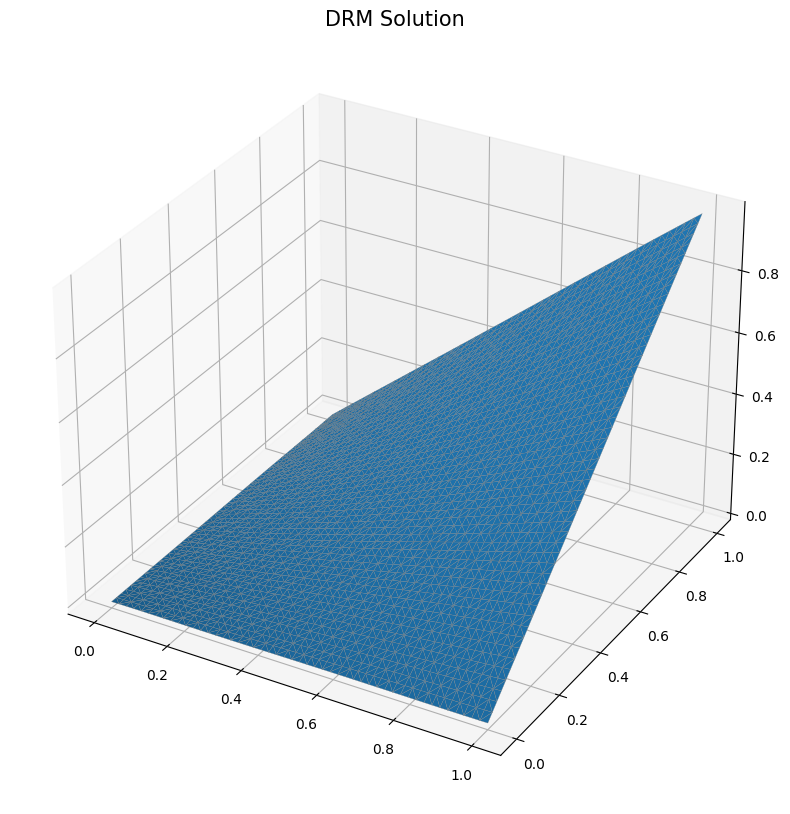

In [ ]:
fig = plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
plt.title('DRM Solution', fontsize=15)


x=xy_grid[:,0].tolist()
y=xy_grid[:,1].tolist()
z=network(xy_grid).tolist()

xx = np.array(x)
yy = np.array(y)
zz_pred = np.array(z)[:,0]


trisurf = ax.plot_trisurf(xx, yy, zz_pred,
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey')

plt.show()

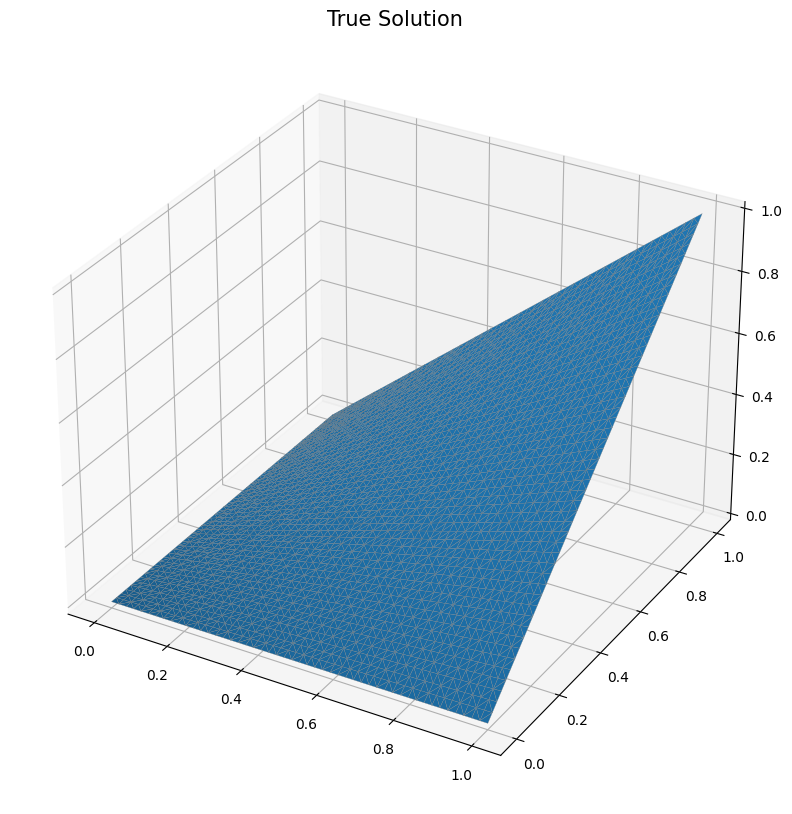

In [ ]:
fig = plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
plt.title('True Solution', fontsize=15)

x=xy_grid[:,0].tolist()
y=xy_grid[:,1].tolist()
z=true.tolist()

xx = np.array(x)
yy = np.array(y)
zz_true = np.array(z)[:,0]


trisurf = ax.plot_trisurf(xx, yy, zz_true,
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey')

plt.show()
